In [1]:
from lumia.obsdb import obsdb # TODO: remove this line

from numpy import sqrt, mean, logspace, log10
from pandas import read_csv, DataFrame, to_datetime, concat, Timedelta, date_range, merge
from geopandas import GeoDataFrame, points_from_xy, read_file
from datetime import datetime
from figures import *

from matplotlib.pyplot import subplots, gca
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

from xarray import open_dataset, Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates

# <a id="top"></a>Table of contents

1. [Figure 1](#Figure-1)
2. [Figure 2](#Figure-2)
3. [Figure 3](#Figure-3)
4. [Figure 4](#Figure-4)
5. [Figure 5](#Figure-5)
6. [Figure 6](#Figure-6)
7. [Figure 7](#Figure-7)
8. [Appendix A1](#Appendix-A1)
9. [Appendix A2](#Appendix-A2)

### Figure 1.

In [2]:
# Run this cell to load the station list into a GeoDataFrame

stationList = read_csv('data/fig1/stations.csv')

stationList = GeoDataFrame(stationList, geometry=points_from_xy(stationList.lon, stationList.lat), crs='EPSG:4326')

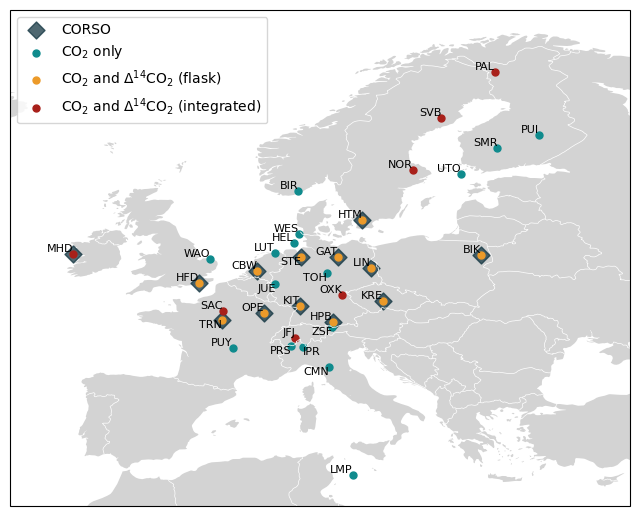

In [3]:
# Run this cell to plot the stations on a map

fig, ax = subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')

ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')
ax.set_extent([-15, 35, 33, 73], crs=ccrs.PlateCarree())

a = [ax.scatter(j.geometry.x, j.geometry.y, marker='D', c='#143642', s=75, label='CORSO', alpha=0.75) for i,j in stationList.iterrows() if j.corso == 1]
b = [ax.scatter(j.geometry.x, j.geometry.y, marker='o', c='#0F8B8D', s=25, label='CO$_2$ only') for i,j in stationList.iterrows() if (j.corso == 0) & (j.base_type != 'intg')]
c = [ax.scatter(j.geometry.x, j.geometry.y, marker='o', c='#EC9A29', s=25, label=r'CO$_2$ and $\Delta^{14}$CO$_2$ (flask)') for i,j in stationList.iterrows() if (j.corso_type == 'hrly')]
d = [ax.scatter(j.geometry.x, j.geometry.y, marker='o', c='#A8201A', s=25, label=r'CO$_2$ and $\Delta^{14}$CO$_2$ (integrated)') for i,j in stationList.iterrows() if (j.corso_intg == 'intg')]

all_scatter = a + b + c + d

texts = [ax.annotate(j.code, (j.geometry.x, j.geometry.y), fontsize=8, ha=j.ha, va=j.va) for i, j in stationList.iterrows()]

# adjust_text(texts, objects=all_scatter, force_points=0.3, force_text=0.3, expand_points=(2, 2), expand_text=(2, 2), expand_axes=True)

handles1, labels1 = gca().get_legend_handles_labels()
by_label = dict(zip(labels1, handles1))

handles = by_label.values()
labels = by_label.keys()

ax.legend(handles, labels)

fig.savefig('figures/fig1.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)

### Figure 2. 

In [6]:
# TODO: Preprocessing, you can remove this cell

Forward_ALL_True = obsdb('/lunarc/nobackup/projects/ghg_inv/carlos/data/output/Paper2/Experiments1/Forward_ALL_True/observations.fwd.tar.gz')

Forward_ALL_Prior = obsdb('/lunarc/nobackup/projects/ghg_inv/carlos/data/output/Paper2/Experiments1/Forward_ALL_Prior/observations.fwd.tar.gz')

Forward_ALL_True.observations.loc[:, 'mix_fg_CO2'] = Forward_ALL_True.observations.filter(regex='mix_co2').sum(axis=1) + Forward_ALL_True.observations.loc[:, 'mix_bg_CO2']

Forward_ALL_True.observations.rename(columns={'mix_co2_fossil': 'fossil_True',
                                              'mix_c14_nuclear': 'nuclear_True',
                                              'mix_co_fossil': 'co_fossil_True',
                                              }, inplace=True)

Forward_ALL_Prior.observations.rename(columns={'mix_co2_fossil': 'fossil_Prior',
                                              'mix_c14_nuclear': 'nuclear_Prior',
                                              'mix_co_fossil': 'co_fossil_Prior',
                                              }, inplace=True)

Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14') & (Forward_ALL_True.observations.type == 'hrly'), 'co_fossil_True'] = Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'co') & (Forward_ALL_True.observations.type == 'hrly'), 'co_fossil_True'].values

Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14') & (Forward_ALL_True.observations.type == 'hrly'), 'co_fossil_Prior'] = Forward_ALL_Prior.observations.loc[(Forward_ALL_Prior.observations.tracer == 'co') & (Forward_ALL_Prior.observations.type == 'hrly'), 'co_fossil_Prior'].values
Forward_ALL_True.observations.loc[:, 'fossil_Prior'] = Forward_ALL_Prior.observations.loc[:, 'fossil_Prior']
Forward_ALL_True.observations.loc[:, 'nuclear_Prior'] = Forward_ALL_Prior.observations.loc[:, 'nuclear_Prior']

Forward_CORSO = Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14') & (~Forward_ALL_True.observations.fossil_True.isna()) & (Forward_ALL_True.observations.site.isin(Forward_ALL_True.sites.loc[(Forward_ALL_True.sites.corso_type == 'hrly')].index))]

Forward_CORSO.reset_index(drop=True, inplace=True)

tp = '_Prior'

Forward_CORSO['ffCO2'] = 0
Forward_CORSO.loc[Forward_CORSO[f'fossil{tp}'] >= 4, 'ffCO2'] = 1

Forward_CORSO['ffCO'] = 0
Forward_CORSO.loc[Forward_CORSO['co_fossil_True'] >= 0.04, 'ffCO'] = 1
Forward_CORSO.loc[(Forward_CORSO.site == 'OPE') & (Forward_CORSO['co_fossil_True'] >= 0.032), 'ffCO'] = 1

Forward_CORSO['nuc14C'] = 0
Forward_CORSO.loc[Forward_CORSO[f'nuclear{tp}'] <= 1, 'nuc14C'] = 1

Forward_CORSO['ffCO2_ffCO'] = 0
Forward_CORSO.loc[(Forward_CORSO['ffCO2'] == 1) & (Forward_CORSO['ffCO'] == 1), 'ffCO2_ffCO'] = 1

Forward_CORSO['ffCO2_nuc14C'] = 0
Forward_CORSO.loc[(Forward_CORSO['ffCO2'] == 1) & (Forward_CORSO['nuc14C'] == 1), 'ffCO2_nuc14C'] = 1

Forward_CORSO_HRLY = Forward_CORSO.loc[(Forward_CORSO.time.dt.year == 2018) & (Forward_CORSO.tracer == 'c14') & (Forward_CORSO.type == 'hrly')]

Forward_CORSO_HRLY.loc[:, 'time_LT'] = to_datetime(Forward_CORSO_HRLY.time_LT)

Forward_CORSO_HRLY_13LT = Forward_CORSO_HRLY.loc[[t.hour == 13 for t in Forward_CORSO_HRLY.time_LT]]

Forward_CORSO_HRLY_13LT.loc[:, 'obs_permil'] = 1000 * Forward_CORSO_HRLY_13LT.loc[:, 'mix'] / Forward_CORSO_HRLY_13LT.loc[:, 'mix_fg_CO2']

Forward_CORSO_HRLY_13LT.to_csv('data/fig2/fig2.csv', index=False)

/tmp/ipykernel_684554/946611919.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forward_CORSO['ffCO2'] = 0
/tmp/ipykernel_684554/946611919.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Forward_CORSO['ffCO'] = 0
/tmp/ipykernel_684554/946611919.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [7]:
# Run this cell to load the synthetic data into a DataFrame

Forward_CORSO_HRLY_13LT = read_csv('data/fig2/fig2.csv', parse_dates=['time', 'time_LT'])

Forward_CORSO_HRLY_13LT = Forward_CORSO_HRLY_13LT.set_index('time', drop=False)

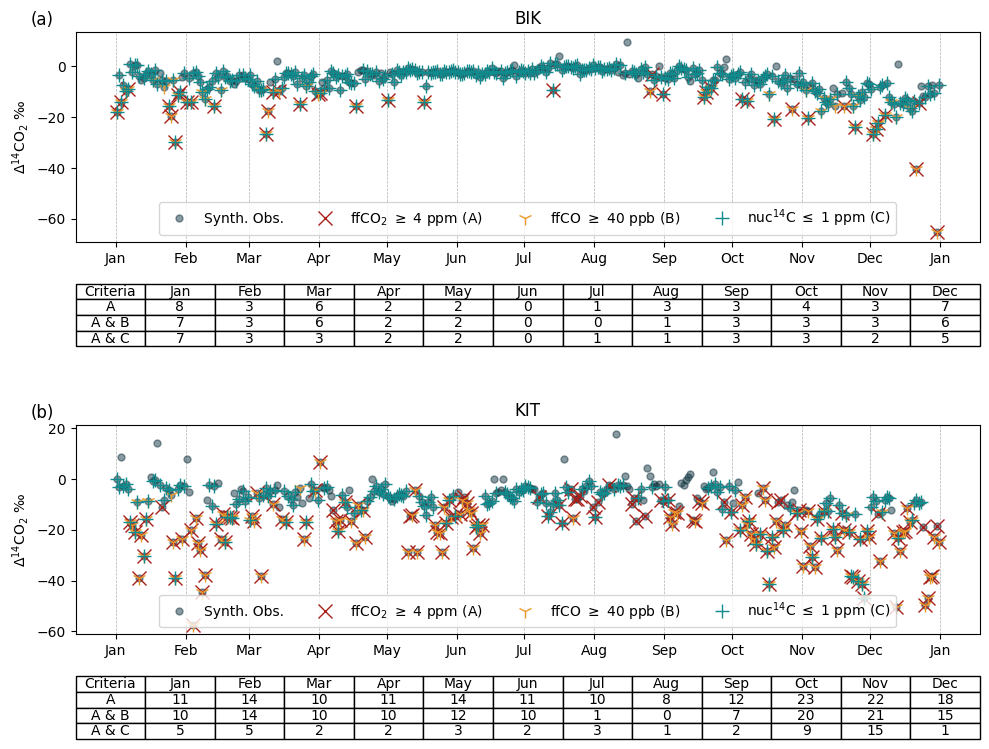

In [10]:
# Run this cell to plot the synthetic data

f, ax = subplots(2, 1, figsize=(10, 8))

ax = ax.flatten()

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#A8201A', '#143642']


for i, site in enumerate(['BIK', 'KIT']):

    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site)].obs_permil, label='Synth. Obs.', lw=0, marker='o', markersize=5, color=clr[-1], alpha=0.5) 
    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO2 == 1)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO2 == 1)].obs_permil, label=r'ffCO$_2$ $\geq$ 4 ppm (A)', lw=0, marker='x', markersize=10, color=clr[3]) 
    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO == 1)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO == 1)].obs_permil, label=r'ffCO $\geq$ 40 ppb (B)', lw=0, marker='1', markersize=10, color=clr[1]) 
    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.nuc14C == 1)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.nuc14C == 1)].obs_permil, label=r'nuc$^{14}$C $\leq$ 1 ppm (C)', lw=0, marker='+', markersize=10, color=clr[0]) 

    ax[i].grid(which='major', axis='x', linestyle='--', linewidth=0.5)

    # Select only numeric columns for resampling
    numeric_columns = Forward_CORSO_HRLY_13LT.loc[Forward_CORSO_HRLY_13LT.site == site].select_dtypes(include=['number'])

    # Set the index and resample
    monthly_counts = numeric_columns.resample('M').sum()

    table_data = [
        ['A'] + list(monthly_counts['ffCO2']),
        ['A & B'] + list((monthly_counts['ffCO2_ffCO'])),
        ['A & C'] + list((monthly_counts['ffCO2_nuc14C']))
    ]

    months = mdates.MonthLocator()  # set the locator to months
    date_fmt = mdates.DateFormatter('%b')  # set the formatter to month abbreviations
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(date_fmt)
    # Make the x-axis label horizontal 
    for tick in ax[i].get_xticklabels():
       tick.set_rotation(0)
       tick.set_horizontalalignment("center")
    
    months_labels = [datetime(2018, m, 1).strftime('%b') for m in range(1, 13)]
    table = ax[i].table(cellText=table_data, colLabels=['Criteria'] + months_labels, cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)
    
    ax[i].set_ylabel(r'$\Delta^{14}$CO$_2$ ‰')

    ax[i].legend(ncols=4, loc='lower center')#, frameon=False)
    ax[i].set_title(site)

    # Add letter labels
    ax[i].text(-0.05, 1.1, f'({chr(97 + i)})', transform=ax[i].transAxes, fontsize=12, va='top')

f.tight_layout()

f.savefig('figures/fig2.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)

### Figure 3.

In [15]:
# TODO: Preprocessing, you can remove this cell

db_3t = read_csv('/home/carlosg/lu2023-12-19/carlos/data/observations/Obs_Synth_bg.csv', index_col=0)

db_3t['time'] = to_datetime(db_3t['time'])

Forward_ALL_True = obsdb('/lunarc/nobackup/projects/ghg_inv/carlos/data/output/Paper2/Experiments1/Forward_ALL_True/observations.fwd.tar.gz')

Forward_ALL_True.observations.loc[:, 'mix_fg_CO2'] = Forward_ALL_True.observations.filter(regex='mix_co2').sum(axis=1) + Forward_ALL_True.observations.loc[:, 'mix_bg_CO2']

Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14'), 'obs_permil'] = 1000 * Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14'), 'mix'] / Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14'), 'mix_fg_CO2']

def wk_intg(db):

    db_wk = []

    for i, j in db.iterrows():
        # Create a time series of each j.time minus j.integration in days and add it to the dataframe
        try:
            df_obs = DataFrame({'site':j.site, 'time': date_range(j.time, j.time + Timedelta(j.integration, unit='d'), freq='D'), 'obs_permil': j.obs, 'mix_bg_D14C': j.mix_bg_D14C})
        except:
            df_obs = DataFrame({'site':j.site, 'time': date_range(j.time, j.time + Timedelta(j.integration, unit='d'), freq='D'), 'obs_permil': j.obs_permil})
        db_wk.append(df_obs)

    db_wk = concat(db_wk)

    return db_wk

db_3t = db_3t.loc[db_3t.time.dt.year == 2018]
Forward_ALL_True.observations = Forward_ALL_True.observations.loc[Forward_ALL_True.observations.time.dt.year == 2018]

db_3t_real = db_3t.loc[(db_3t.tracer == 'c14') & (db_3t.obs_type == 'real')]
db_3t_real_wk = wk_intg(db_3t_real)

db_flex = Forward_ALL_True.observations.loc[(Forward_ALL_True.observations.tracer == 'c14') & (Forward_ALL_True.observations.type == 'intg') & (Forward_ALL_True.observations.site.isin(db_3t_real.site.unique()))]
db_flex = wk_intg(db_flex)

db_3t_real_wk.to_csv('data/fig3/fig3_real.csv', index=False)
db_flex.to_csv('data/fig3/fig3_synth.csv', index=False)


/tmp/ipykernel_684554/2330553327.py:3: DtypeWarning: Columns (2,3,5,6,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  db_3t = read_csv('/home/carlosg/lu2023-12-19/carlos/data/observations/Obs_Synth_bg.csv', index_col=0)


In [17]:
# Read the real and synthetic data

db_3t_real_wk = read_csv('data/fig3/fig3_real.csv', parse_dates=['time'])
db_flex = read_csv('data/fig3/fig3_synth.csv', parse_dates=['time'])

/tmp/ipykernel_684554/3441362718.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_flex_site['time'] = db_flex_site.time.dt.date
/tmp/ipykernel_684554/3441362718.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_3t_real_wk_site['time'] = db_3t_real_wk_site.time.dt.date
/tmp/ipykernel_684554/3441362718.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

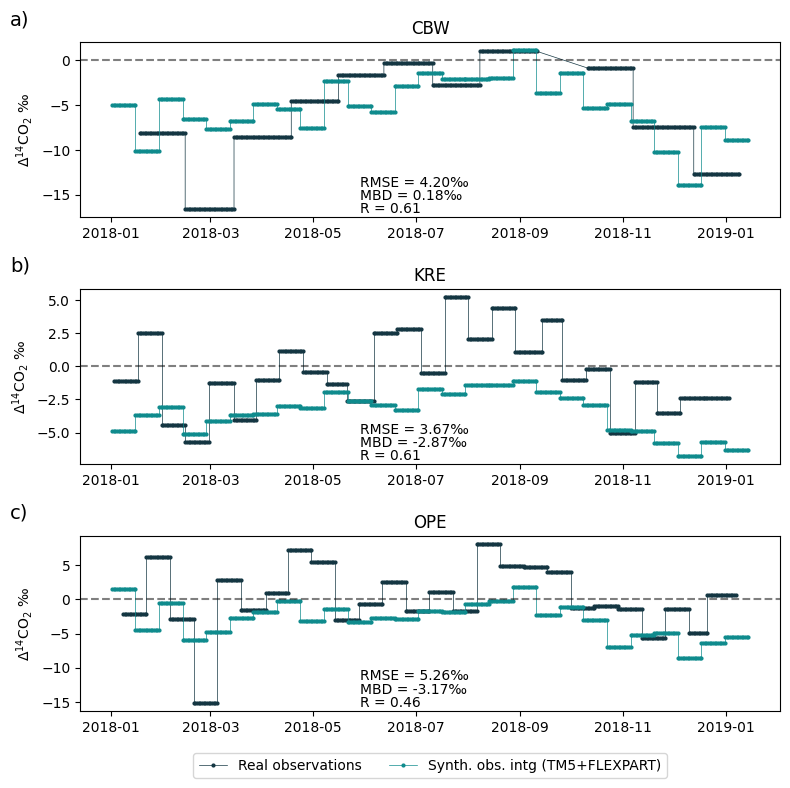

In [20]:
# Plot the real and synthetic data

f, ax = subplots(3, 1, figsize=(8,8))#, sharex=True)

ax = ax.flatten()

tr = ['CO2', 'D14C']
lbl = ['ppm', 'permil']

tracer = 'c14'

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#A8201A', '#143642']

for i, site in enumerate(['CBW', 'KRE', 'OPE']):

    ax[i].plot(db_3t_real_wk.loc[(db_3t_real_wk.site == site), 'time'], db_3t_real_wk.loc[(db_3t_real_wk.site == site), 'obs_permil'], color=clr[-1], label='Real observations', lw=0.5, marker='o', markersize=2)
    
    ax[i].plot(db_flex.loc[(db_flex.site == site), 'time'], db_flex.loc[(db_flex.site == site), 'obs_permil'], color=clr[0], label='Synth. obs. intg (TM5+FLEXPART)', lw=0.5, marker='o', markersize=2)

    # Calculate R^2
    db_flex_site = db_flex.loc[(db_flex.site == site)]
    db_flex_site['time'] = db_flex_site.time.dt.date

    db_3t_real_wk_site = db_3t_real_wk.loc[(db_3t_real_wk.site == site)]
    db_3t_real_wk_site['time'] = db_3t_real_wk_site.time.dt.date

    db_con = merge(db_3t_real_wk_site, db_flex_site, on='time', how='outer')

    db_con = db_con.loc[~db_con.obs_permil_x.isna()]
    db_con = db_con.loc[~db_con.obs_permil_y.isna()]

    R = db_con.obs_permil_y.corr(db_con.obs_permil_x)
    MBD = db_con.obs_permil_y.subtract(db_con.obs_permil_x).mean()
    # Calculate RMSE
    RMSE = sqrt(mean((db_con.obs_permil_y - db_con.obs_permil_x)**2))

    ax[i].text(0.4, 0.025, f'R = {R:.2f}', transform=ax[i].transAxes)
    ax[i].text(0.4, 0.1, f'MBD = {MBD:.2f}‰', transform=ax[i].transAxes)
    ax[i].text(0.4, 0.175, f'RMSE = {RMSE:.2f}‰', transform=ax[i].transAxes)

    ax[i].set_title(f'{site}')
    ax[i].set_ylabel('$\Delta^{14}$CO$_2$ ‰') 

    lbl = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)', 't)', 'u)', 'v)', 'w)', 'x)', 'y)', 'z)']

    ax[i].text(-0.1, 1.1, lbl[i], transform=ax[i].transAxes, fontsize=14)
    # Put a legend below current axis
    if (i == 2):
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

    # Add a dashed line at 0
    ax[i].axhline(0, color='k', linestyle='--', alpha=0.5)

f.tight_layout()

f.savefig('figures/fig3.png', dpi=300, bbox_inches='tight')


[Back to Top](#top)

### Figure 4.

In [2]:
# TODO: Preprocessing, you can remove this cell

path = '/home/carlosg/lu2023-12-19/carlos/data/output'

osses = [
'Paper2/Experiments1/BASE_BAU',
'Paper2/Experiments1/CORSO_BAU',
 ]

alias = ['BASE', 'CORSO']

cat = 'co2/fossil'
time_span = 'Monthly'

Regions = ['Study Domain', 'Western Europe', 'DE', 'FR', 'Benelux', 'British Isles']
Reg = ['Study Domain', 'Western/Central Europe', 'Germany', 'France', 'Benelux', 'British Isles']

df_all = DataFrame()

for i, reg in enumerate(Regions):

    ds_truth, unit = toTimeUnits(os.path.join(path, 'Paper2/Experiments1/Forward_ALL_True', 'modelData.fwd.nc'), cat, time_span, reg)
    ds_truth = ds_truth.sel(time=slice('2018-01-01', '2018-12-31')) 

    df_all.loc[:, 'time'] = ds_truth.time.values
    df_all.loc[:, f'truth {reg}'] = ds_truth.emis.values
    if 'Domain' not in reg:
        df_all.loc[:, f'truth {reg} total frac'] = ds_truth.emis.values / df_all.loc[:, f'truth Study Domain'].values

    ds_apri, unit = toTimeUnits(os.path.join(path, osses[0], 'modelData.apri.nc'), cat, time_span, reg)
    ds_apri = ds_apri.sel(time=slice('2018-01-01', '2018-12-31'))#.resample(time='3M').mean()

    df_all.loc[:, f'prior {reg}'] = ds_apri.emis.values
    df_all.loc[:, f'prior bias {reg}'] = abs(ds_apri.emis.values - ds_truth.emis.values)
    df_all.loc[:, f'prior rel bias {reg}'] = df_all.loc[:, f'prior bias {reg}'].values / ds_apri.emis.values
    
    ds_apri_unc = []

    for k in range(25):
        try:
            d, u = toTimeUnits(os.path.join(path, 'ensemble_' + alias[0] + '_BAU', alias[0] + '_BAU' + f'_{k}', f'modelData.apri.nc'), cat, time_span, reg)
            ds_apri_unc.append(d.emis.values)
        except:
            continue
    
    ds_apri_unc = array(ds_apri_unc)
    ds_apri_unc = ds_apri_unc.std(axis=0)

    ds_apri_time = to_datetime(ds_apri.time)

    df_all.loc[:, f'prior unc {reg}'] = ds_apri_unc
    df_all.loc[:, f'prior unc {reg} frac'] = ds_apri_unc / ds_apri.emis.values

    for j, osse in enumerate(osses):
        
        ds_apos, unit = toTimeUnits(os.path.join(path, osse, 'modelData.apos.nc'), cat, time_span, reg)
        ds_apos = ds_apos.sel(time=slice('2018-01-01', '2018-12-31'))

        df_all.loc[:, f'post {alias[j]} {reg}'] = ds_apos.emis.values
        df_all.loc[:, f'post bias {alias[j]} {reg}'] = abs(ds_apos.emis.values - ds_truth.emis.values)
        df_all.loc[:, f'post bias red {alias[j]} {reg}'] = 1 - df_all.loc[:, f'post bias {alias[j]} {reg}'].values / df_all.loc[:, f'prior bias {reg}'].values

        path_unc = os.path.join(path, 'ensemble_' + alias[j] + '_BAU')
        # Make list of all folders in path_unc
        folders = [f for f in os.listdir(path_unc) if os.path.isdir(os.path.join(path_unc, f))]

        ds_apos_unc = []
        k = 0
        for fldr in folders:
            try:
                d, u = toTimeUnits(os.path.join(path_unc, fldr, f'modelData.apos.nc'), cat, time_span, reg)
                ds_apos_unc.append(d.emis.values)
                k += 1
            except:
                continue
            if k == 25:
                break
        
        ds_apos_unc = array(ds_apos_unc)
        ds_apos_unc = ds_apos_unc.std(axis=0)

        ds_apos_time = to_datetime(ds_apos.time)

        df_all.loc[:, f'post unc {alias[j]} {reg}'] = ds_apos_unc
        df_all.loc[:, f'post unc red {alias[j]} {reg}'] = 1 - ds_apos_unc / ds_apri_unc

df_all.to_csv('data/fig4/fig4.csv', index=False)

/tmp/ipykernel_1405721/1505357784.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all.loc[:, f'post unc {alias[j]} {reg}'] = ds_apos_unc
/tmp/ipykernel_1405721/1505357784.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all.loc[:, f'post unc red {alias[j]} {reg}'] = 1 - ds_apos_unc / ds_apri_unc


In [5]:
# Run this cell to load the NUTS regions into a GeoDataFrame, and assign each station to a region

lndmsk = read_file('/home/carlosg/lu2023-12-19/carlos/scripts/NUTS/NUTS_RG_20M_2021_3857.shp', crs='EPSG:3857')
lndmsk = lndmsk.loc[lndmsk['LEVL_CODE'] == 0]
lndmsk = lndmsk.to_crs('EPSG:4326')
lndmsk['Region'] = 'Europe'

Regions = {
    'Northern Europe': ['DK', 'EE', 'FI', 'LV', 'LT', 'NO', 'SE'],
    'British Isles': ['UK', 'IE'],
    'Western Europe': ['AT', 'BE', 'FR', 'DE', 'LI', 'LU', 'NL', 'CH'],
    'Eastern Europe': ['BG', 'CZ', 'HU', 'PL', 'RO', 'SK'],
    'Southern Europe': ['AL', 'HR', 'EL', 'IT', 'MT', 'ME', 'MK', 'PT', 'RS', 'SI', 'ES'],
    'Benelux': ['BE', 'NL', 'LU'],
}

for region_name, countries in Regions.items():
    lndmsk.loc[lndmsk['CNTR_CODE'].isin(countries), 'Region'] = region_name

stationList = read_csv('data/fig1/stations.csv')

stationList = GeoDataFrame(stationList, geometry=points_from_xy(stationList.lon, stationList.lat), crs='EPSG:4326')

/tmp/ipykernel_1587547/263764878.py:37: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_1587547/263764878.py:54: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_1587547/263764878.py:54: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_1587547/263764878.py:54: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i],

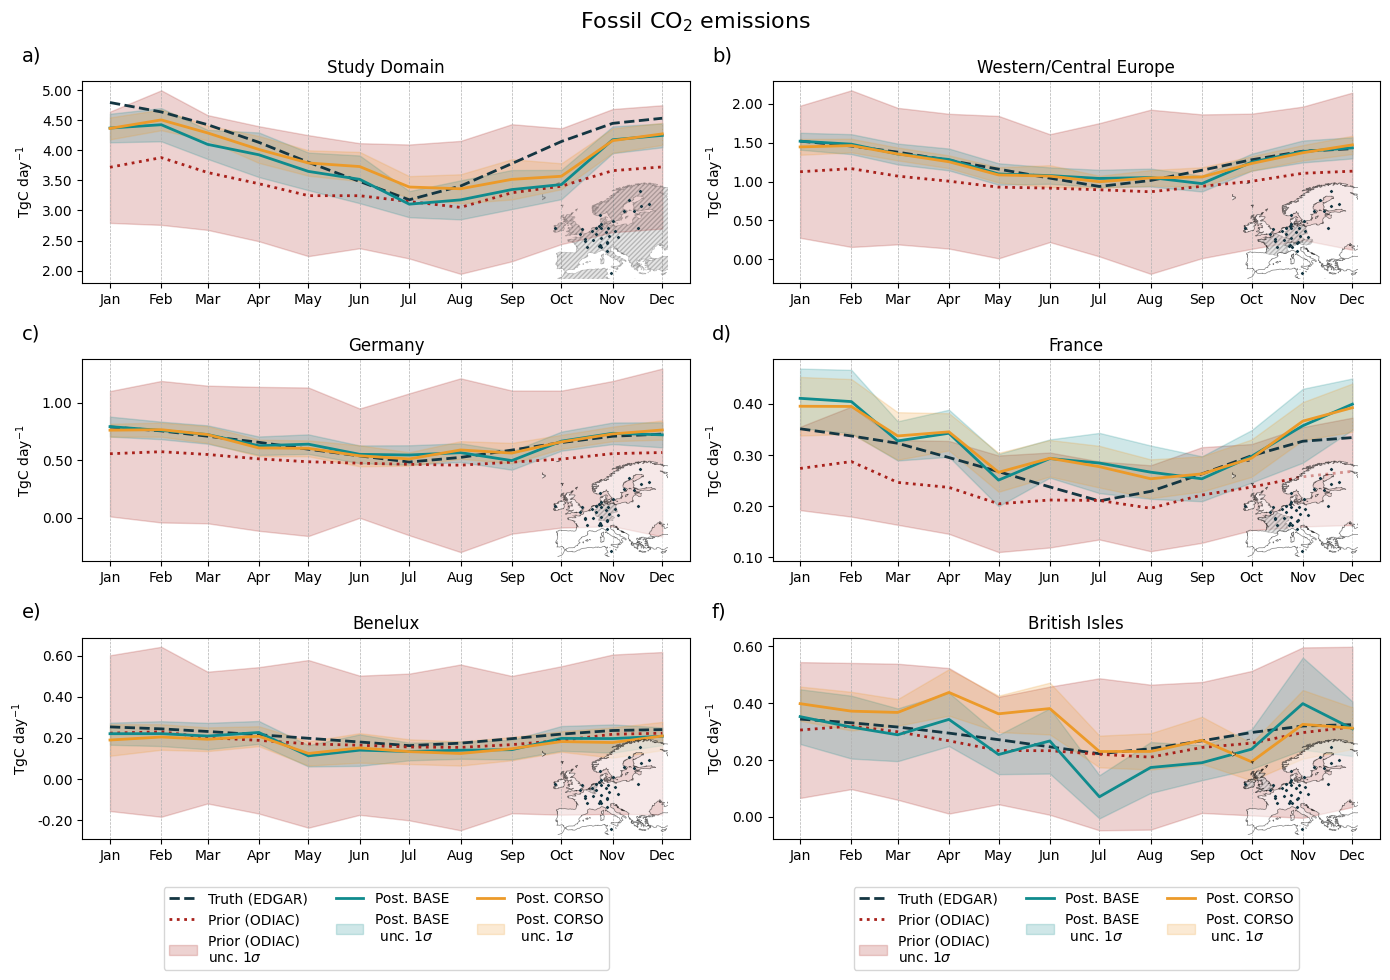

In [6]:
# Run this cell to plot the results of the first experiment

path = 'data/fig4/fig4.csv'

df_all = read_csv(path, parse_dates=['time'])

osses = [
'BASE_BAU',
'CORSO_BAU',
 ]

alias = ['BASE', 'CORSO']

cat = 'co2/fossil'
time_span = 'Monthly'

fig, ax = subplots(3, 2, figsize=(14, 10))

ax = ax.flatten()

Regions = ['Study Domain', 'Western Europe', 'DE', 'FR', 'Benelux', 'British Isles']
Reg = ['Study Domain', 'Western/Central Europe', 'Germany', 'France', 'Benelux', 'British Isles']

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#143642']

inset_x = 0.86
inset_y = 0.27
inset_size = 0.5

for i, reg in enumerate(Regions):

    if i == 0:
        mini_map_area = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree(), facecolor=None, frameon=False)
        mini_map_area.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black', linewidth=0.5, alpha=0.2, hatch='///////')
        mini_map_area.set_extent([-15, 35, 33, 73], crs=ccrs.PlateCarree())

        ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
                                inset_y - inset_size / 2,
                                inset_size,
                                inset_size])
        mini_map_area.set_axes_locator(ip)
        [mini_map_area.scatter(j.geometry.x, j.geometry.y, marker='D', c='#143642', s=1, zorder=20) for i,j in stationList.iterrows()]

    else:
        mini_map_area2 = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree(), facecolor=None, frameon=False)
        mini_map_area2.add_feature(cfeature.LAND, facecolor='white', alpha=0.5, edgecolor='black', linewidth=0.5)
        if len(Regions[i]) == 2:
            col = 'CNTR_CODE'
        else:
            col = 'Region'
        mini_map_area2.add_geometries(lndmsk.loc[lndmsk[col] == Regions[i]].geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='black', linewidth=0.5, alpha=0.2, hatch='///////')
        mini_map_area2.set_extent([-15, 35, 33, 73], crs=ccrs.PlateCarree())

        ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
                                inset_y - inset_size / 2,
                                inset_size,
                                inset_size])
        mini_map_area2.set_axes_locator(ip)
        [mini_map_area2.scatter(j.geometry.x, j.geometry.y, marker='D', c='#143642', s=1, zorder=20) for i,j in stationList.iterrows()]

    ax[i].plot(df_all.time, df_all.loc[:, f'truth {reg}'], label=f'Truth (EDGAR)', linestyle='dashed', color='#143642', linewidth=2)

    ax[i].plot(df_all.time, df_all.loc[:, f'prior {reg}'], label=f'Prior (ODIAC)', linestyle='dotted', color='#A8201A', linewidth=2)

    ax[i].fill_between(df_all.time, df_all.loc[:, f'prior {reg}'] - df_all.loc[:, f'prior unc {reg}']/2, df_all.loc[:, f'prior {reg}'] + df_all.loc[:, f'prior unc {reg}']/2, color='#A8201A', alpha=0.2, label= 'Prior (ODIAC) \nunc. 1$\\sigma$')

    for j, osse in enumerate(osses):
        
        ax[i].plot(df_all.time, df_all.loc[:, f'post {alias[j]} {reg}'], label=f'Post. {alias[j]}', linestyle='-', color=clr[j], linewidth=2)

        ax[i].fill_between(df_all.time, df_all.loc[:, f'post {alias[j]} {reg}'] - df_all.loc[:, f'post unc {alias[j]} {reg}']/2, df_all.loc[:, f'post {alias[j]} {reg}'] + df_all.loc[:, f'post unc {alias[j]} {reg}']/2, color=clr[j], alpha=0.2, label= 'Post. ' + alias[j] + '\n unc. 1$\\sigma$')

    ax[i].set_title(f'{Reg[i]}')
    ax[i].set_ylabel('TgC day$^{-1}$')
    ax[i].set_xlabel('')
    ax[i].grid(which='major', axis='x', linestyle='--', linewidth=0.5)
    
    months = mdates.MonthLocator()  # set the locator to months
    date_fmt = mdates.DateFormatter('%b')  # set the formatter to month abbreviations
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(date_fmt)
    # Make the x-axis label horizontal 
    for tick in ax[i].get_xticklabels():
       tick.set_rotation(0)
       tick.set_horizontalalignment("center")
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    lbl = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

    ax[i].text(-0.1, 1.1, lbl[i], transform=ax[i].transAxes, fontsize=14)
    # Put a legend below current axis
    if (i == 4) or (i == 5):
        # Avoid repeating labels
        handles, labels = ax[i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        # Create the legend
        ax[i].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# Add a general title for the figure
fig.suptitle('Fossil CO$_2$ emissions', fontsize=16)

fig.tight_layout()

fig.savefig(f'figures/fig4.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)

### Figure 5.

In [7]:
#TODO: Preprocessing, you can remove this cell

path = '/home/carlosg/lu2023-12-19/carlos/data/output'

osses = [
'Paper2/Experiments1/CORSO_BAU',
'Paper2/Experiments1/CORSO_ffCO2',
'Paper2/Experiments1/CORSO_ffCO2_ffCO',
 ]

alias = [
    'CORSO',
    'CORSO_ffCO2',
    'CORSO_ffCO2_ffCO',
]

cat = 'co2/fossil'
time_span = 'Monthly'

Regions = ['Western Europe', 'DE']
Reg = ['Western/Central Europe', 'Germany']

df_all = DataFrame()

for i, reg in enumerate(Regions):

    ds_truth, unit = toTimeUnits(os.path.join(path, 'Paper2/Experiments1/Forward_ALL_True', 'modelData.fwd.nc'), cat, time_span, reg)
    ds_truth = ds_truth.sel(time=slice('2018-01-01', '2018-12-31'))

    ds_apri, unit = toTimeUnits(os.path.join(path, osses[0], 'modelData.apri.nc'), cat, time_span, reg)
    ds_apri = ds_apri.sel(time=slice('2018-01-01', '2018-12-31'))

    df_all.loc[:, 'time'] = ds_truth.time.values
    df_all.loc[:, f'truth {reg}'] = ds_truth.emis.values

    df_all.loc[:, f'prior {reg}'] = ds_apri.emis.values
    df_all.loc[:, f'prior bias {reg}'] = abs(ds_apri.emis.values - ds_truth.emis.values)
    df_all.loc[:, f'prior rel bias {reg}'] = df_all.loc[:, f'prior bias {reg}'].values / ds_apri.emis.values

    if 'ffCO2' in alias[j]:
        path_unc = os.path.join(path, 'ensemble_' + alias[j])
    else:
        path_unc = os.path.join(path, 'ensemble_' + alias[j] + '_BAU')
    # Make list of all folders in path_unc
    folders = [f for f in os.listdir(path_unc) if os.path.isdir(os.path.join(path_unc, f))]
    
    ds_apri_unc = []
    k = 0
    for fldr in folders:
        try:
            d, u = toTimeUnits(os.path.join(path_unc, fldr, f'modelData.apri.nc'), cat, time_span, reg)
            ds_apri_unc.append(d.emis.values)
            k += 1
        except:
            continue
        if k == 25:
            break
    
    ds_apri_unc = array(ds_apri_unc)
    ds_apri_unc = ds_apri_unc.std(axis=0)

    df_all.loc[:, f'prior unc {reg}'] = ds_apri_unc
    df_all.loc[:, f'prior unc {reg} frac'] = ds_apri_unc / ds_apri.emis.values

    for j, osse in enumerate(osses):
        
        ds_apos, unit = toTimeUnits(os.path.join(path, osse, 'modelData.apos.nc'), cat, time_span, reg)
        ds_apos = ds_apos.sel(time=slice('2018-01-01', '2018-12-31'))

        df_all.loc[:, f'post {alias[j]} {reg}'] = ds_apos.emis.values
        df_all.loc[:, f'post bias {alias[j]} {reg}'] = abs(ds_apos.emis.values - ds_truth.emis.values)
        df_all.loc[:, f'post bias red {alias[j]} {reg}'] = 1 - df_all.loc[:, f'post bias {alias[j]} {reg}'].values / df_all.loc[:, f'prior bias {reg}'].values
        
        if 'ffCO2' in alias[j]:
            path_unc = os.path.join(path, 'ensemble_' + alias[j])
        else:
            path_unc = os.path.join(path, 'ensemble_' + alias[j] + '_BAU')
        # Make list of all folders in path_unc
        folders = [f for f in os.listdir(path_unc) if os.path.isdir(os.path.join(path_unc, f))]

        ds_apos_unc = []
        k = 0
        for fldr in folders:
            try:
                d, u = toTimeUnits(os.path.join(path_unc, fldr, f'modelData.apos.nc'), cat, time_span, reg)
                ds_apos_unc.append(d.emis.values)
                k += 1
            except:
                continue
            if k == 25:
                break
        
        ds_apos_unc = array(ds_apos_unc)
        ds_apos_unc = ds_apos_unc.std(axis=0)

        ds_apos_time = to_datetime(ds_apos.time)

        df_all.loc[:, f'post unc {alias[j]} {reg}'] = ds_apos_unc
        df_all.loc[:, f'post unc red {alias[j]} {reg}'] = 1 - ds_apos_unc / ds_apri_unc

df_all.to_csv('data/fig5/fig5.csv')

In [2]:
# Run this cell to load the NUTS regions into a GeoDataFrame, and assign each station to a region

lndmsk = read_file('/home/carlosg/lu2023-12-19/carlos/scripts/NUTS/NUTS_RG_20M_2021_3857.shp', crs='EPSG:3857')
lndmsk = lndmsk.loc[lndmsk['LEVL_CODE'] == 0]
lndmsk = lndmsk.to_crs('EPSG:4326')
lndmsk['Region'] = 'Europe'

Regions = {
    'Northern Europe': ['DK', 'EE', 'FI', 'LV', 'LT', 'NO', 'SE'],
    'British Isles': ['UK', 'IE'],
    'Western Europe': ['AT', 'BE', 'FR', 'DE', 'LI', 'LU', 'NL', 'CH'],
    'Eastern Europe': ['BG', 'CZ', 'HU', 'PL', 'RO', 'SK'],
    'Southern Europe': ['AL', 'HR', 'EL', 'IT', 'MT', 'ME', 'MK', 'PT', 'RS', 'SI', 'ES'],
    'Benelux': ['BE', 'NL', 'LU'],
}

for region_name, countries in Regions.items():
    lndmsk.loc[lndmsk['CNTR_CODE'].isin(countries), 'Region'] = region_name

stationList = read_csv('data/fig1/stations.csv')

stationList = GeoDataFrame(stationList, geometry=points_from_xy(stationList.lon, stationList.lat), crs='EPSG:4326')

/tmp/ipykernel_162152/747430793.py:45: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_162152/747430793.py:45: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_162152/747430793.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


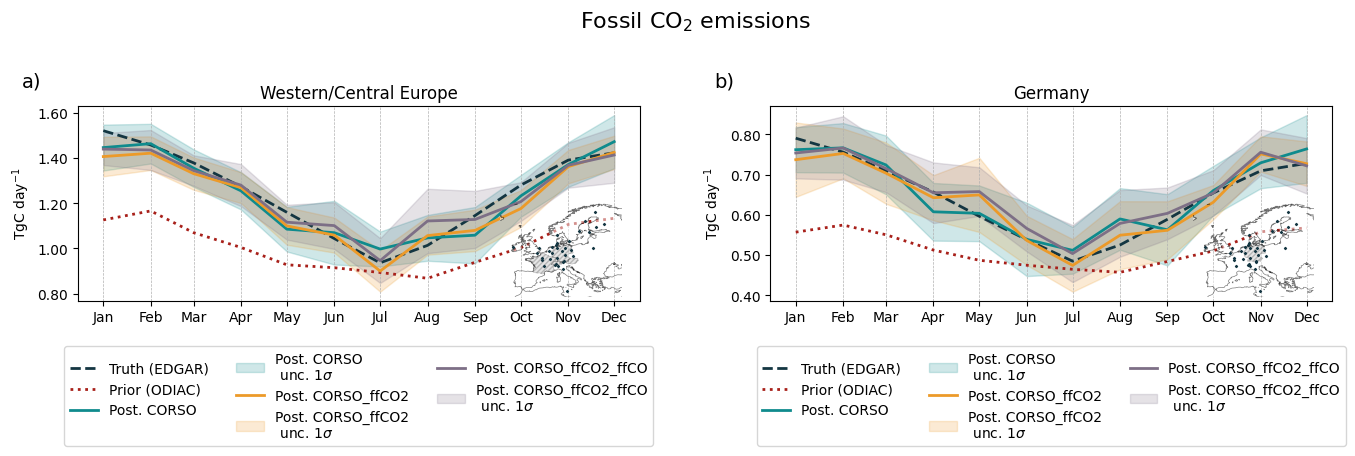

In [3]:
path = 'data/fig5/fig5.csv'

df_all = read_csv(path, parse_dates=['time'])


osses = [
'CORSO_BAU',
'CORSO_ffCO2',
'CORSO_ffCO2_ffCO',
 ]

alias = [
    'CORSO',
    'CORSO_ffCO2',
    'CORSO_ffCO2_ffCO',
]

cat = 'co2/fossil'
time_span = 'Monthly'

fig, ax = subplots(1, 2, figsize=(14, 5))

ax = ax.flatten()

Regions = ['Western Europe', 'DE']
Reg = ['Western/Central Europe', 'Germany']

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#143642']

inset_x = 0.86
inset_y = 0.27
inset_size = 0.5

for i, reg in enumerate(Regions):

    mini_map_area2 = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree(), facecolor=None, frameon=False)
    mini_map_area2.add_feature(cfeature.LAND, facecolor='white', alpha=0.5, edgecolor='black', linewidth=0.5)
    if len(Regions[i]) == 2:
        col = 'CNTR_CODE'
    else:
        col = 'Region'
    mini_map_area2.add_geometries(lndmsk.loc[lndmsk[col] == Regions[i]].geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='black', linewidth=0.5, alpha=0.2, hatch='///////')
    mini_map_area2.set_extent([-15, 35, 33, 73], crs=ccrs.PlateCarree())

    ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
                            inset_y - inset_size / 2,
                            inset_size,
                            inset_size])
    mini_map_area2.set_axes_locator(ip)
    [mini_map_area2.scatter(j.geometry.x, j.geometry.y, marker='D', c='#143642', s=1, zorder=20) for i,j in stationList.iterrows()]

    ax[i].plot(df_all.time, df_all.loc[:, f'truth {reg}'], label=f'Truth (EDGAR)', linestyle='dashed', color='#143642', linewidth=2)

    ax[i].plot(df_all.time, df_all.loc[:, f'prior {reg}'], label=f'Prior (ODIAC)', linestyle='dotted', color='#A8201A', linewidth=2)

    for j, osse in enumerate(osses):
        
        ax[i].plot(df_all.time, df_all.loc[:, f'post {alias[j]} {reg}'], label=f'Post. {alias[j]}', linestyle='-', color=clr[j], linewidth=2)

        ax[i].fill_between(df_all.time, df_all.loc[:, f'post {alias[j]} {reg}'] - df_all.loc[:, f'post unc {alias[j]} {reg}']/2, df_all.loc[:, f'post {alias[j]} {reg}'] + df_all.loc[:, f'post unc {alias[j]} {reg}']/2, color=clr[j], alpha=0.2, label= 'Post. ' + alias[j] + '\n unc. 1$\\sigma$')

    ax[i].set_title(f'{Reg[i]}')
    ax[i].set_ylabel('TgC day$^{-1}$')
    ax[i].set_xlabel('')
    ax[i].grid(which='major', axis='x', linestyle='--', linewidth=0.5)
    
    months = mdates.MonthLocator()  # set the locator to months
    date_fmt = mdates.DateFormatter('%b')  # set the formatter to month abbreviations
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(date_fmt)
    # Make the x-axis label horizontal 
    for tick in ax[i].get_xticklabels():
       tick.set_rotation(0)
       tick.set_horizontalalignment("center")
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    lbl = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

    ax[i].text(-0.1, 1.1, lbl[i], transform=ax[i].transAxes, fontsize=14)
    
    # Put a legend below current axis
    # Avoid repeating labels
    handles, labels = ax[i].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Create the legend
    ax[i].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# Add a general title for the figure
fig.suptitle('Fossil CO$_2$ emissions', fontsize=16)

fig.tight_layout()

fig.savefig(f'figures/fig5.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)

### Figure 6.

In [16]:
# TODO: Preprocessing, you can remove this cell

path = '/home/carlosg/lu2023-12-19/carlos/data/output'

osses = [
'ensemble_CORSO_ffCO2_nuc14Cmin_nuclear/CORSO_ffCO2_nuc14Cmin_nuclear_',
'ensemble_CORSO_ffCO2_nuc14Cmax_nuclear/CORSO_ffCO2_nuc14Cmax_nuclear_',
 ]

alias = [
    'C_ff_nuc14C',
    'C_ff_nuc14Cmax',
]

cat = 'co2/fossil'
time_span = 'Monthly'

Regions = ['Western Europe', 'DE']
Reg = ['Western/Central Europe', 'Germany']

df_all = DataFrame()

for i, reg in enumerate(Regions):

    ds_truth, unit = toTimeUnits(os.path.join(path, 'Paper2/Experiments1/Forward_ALL_True', 'modelData.fwd.nc'), cat, time_span, reg)
    ds_truth = ds_truth.sel(time=slice('2018-01-01', '2018-12-31'))
    
    ds_apri, unit = toTimeUnits(os.path.join(path, 'Paper2/Experiments1/CORSO_ffCO2_ffCO', 'modelData.apri.nc'), cat, time_span, reg)
    ds_apri = ds_apri.sel(time=slice('2018-01-01', '2018-12-31'))

    df_all.loc[:, 'time'] = ds_truth.time.values
    df_all.loc[:, f'truth {reg}'] = ds_truth.emis.values

    df_all.loc[:, f'prior {reg}'] = ds_apri.emis.values
    df_all.loc[:, f'prior bias {reg}'] = abs(ds_apri.emis.values - ds_truth.emis.values)
    df_all.loc[:, f'prior rel bias {reg}'] = df_all.loc[:, f'prior bias {reg}'].values / ds_apri.emis.values

    ds_apri_unc = []
    for k in range(100):
        try:
            d, u = toTimeUnits(os.path.join(path, f'ensemble_CORSO_BAU/CORSO_BAU_{k}', f'modelData.apri.nc'), cat, time_span, reg)
            d = d.sel(time=slice('2018-01-01', '2018-12-31'))
            ds_apri_unc.append(d.emis.values)
        except:
            pass
    
    ds_apri_unc = array(ds_apri_unc)
    ds_apri_unc = ds_apri_unc.std(axis=0)

    df_all.loc[:, f'prior unc {reg}'] = ds_apri_unc
    df_all.loc[:, f'prior unc {reg} frac'] = ds_apri_unc / ds_apri.emis.values

    for j, osse in enumerate(osses):

            # Plot the mean
            if 'min' in osse:
                osse1 = 'Paper2/Experiments1/CORSO_ffCO2_nuc14Cmin'
            elif 'max' in osse:
                osse1 = 'Paper2/Experiments1/CORSO_ffCO2_nuc14Cmax'
            ds_apos, unit = toTimeUnits(os.path.join(path, osse1, 'modelData.apos.nc'), cat, time_span, reg)
            ds_apos = ds_apos.sel(time=slice('2018-01-01', '2018-12-31'))

            df_all.loc[:, f'post {alias[j]} {reg}'] = ds_apos.emis.values
            df_all.loc[:, f'post bias {alias[j]} {reg}'] = abs(ds_apos.emis.values - ds_truth.emis.values)
            df_all.loc[:, f'post bias red {alias[j]} {reg}'] = 1 - df_all.loc[:, f'post bias {alias[j]} {reg}'].values / df_all.loc[:, f'prior bias {reg}'].values

            # if i > 1:
            ds_apos_unc = []
            for k in range(100):
                try:
                    d, u = toTimeUnits(os.path.join(path, osse+f'{k}', 'modelData.apos.nc'), cat, time_span, reg)
                    d = d.sel(time=slice('2018-01-01', '2018-12-31'))
                    ds_apos_unc.append(d.emis.values)
                except:
                    pass
            
            # Plot the std
            ds_apos_unc = array(ds_apos_unc)
            ds_apos_unc = ds_apos_unc.std(axis=0)

            df_all.loc[:, f'post unc {alias[j]} {reg}'] = ds_apos_unc
            df_all.loc[:, f'post unc red {alias[j]} {reg}'] = 1 - ds_apos_unc / ds_apri_unc

df_all.to_csv('data/fig6/fig6.csv')

In [7]:
# Run this cell to load the NUTS regions into a GeoDataFrame, and assign each station to a region

lndmsk = read_file('/home/carlosg/lu2023-12-19/carlos/scripts/NUTS/NUTS_RG_20M_2021_3857.shp', crs='EPSG:3857')
lndmsk = lndmsk.loc[lndmsk['LEVL_CODE'] == 0]
lndmsk = lndmsk.to_crs('EPSG:4326')
lndmsk['Region'] = 'Europe'

Regions = {
    'Northern Europe': ['DK', 'EE', 'FI', 'LV', 'LT', 'NO', 'SE'],
    'British Isles': ['UK', 'IE'],
    'Western Europe': ['AT', 'BE', 'FR', 'DE', 'LI', 'LU', 'NL', 'CH'],
    'Eastern Europe': ['BG', 'CZ', 'HU', 'PL', 'RO', 'SK'],
    'Southern Europe': ['AL', 'HR', 'EL', 'IT', 'MT', 'ME', 'MK', 'PT', 'RS', 'SI', 'ES'],
    'Benelux': ['BE', 'NL', 'LU'],
}

for region_name, countries in Regions.items():
    lndmsk.loc[lndmsk['CNTR_CODE'].isin(countries), 'Region'] = region_name

stationList = read_csv('data/fig1/stations.csv')

stationList = GeoDataFrame(stationList, geometry=points_from_xy(stationList.lon, stationList.lat), crs='EPSG:4326')

/tmp/ipykernel_162152/4002490922.py:42: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_162152/4002490922.py:42: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
/tmp/ipykernel_162152/4002490922.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


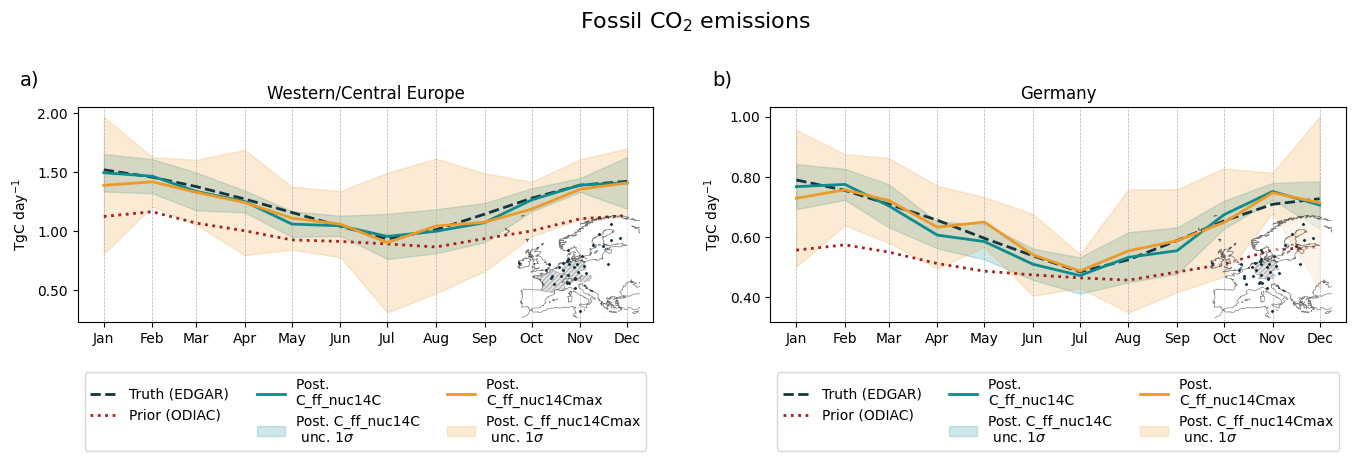

In [8]:
path = 'data/fig6/fig6.csv'

df_all = read_csv(path, parse_dates=['time'])

osses = [
'CORSO_ffCO2_nuc14Cmin_nuclear_',
'CORSO_ffCO2_nuc14Cmax_nuclear_',
 ]

alias = [
    'C_ff_nuc14C',
    'C_ff_nuc14Cmax',
]

cat = 'co2/fossil'
time_span = 'Monthly'

fig, ax = subplots(1, 2, figsize=(14, 5))

ax = ax.flatten()

Regions = ['Western Europe', 'DE']
Reg = ['Western/Central Europe', 'Germany']

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#A8201A', '#143642', 'tab:green']

inset_x = 0.86
inset_y = 0.27
inset_size = 0.5

for i, reg in enumerate(Regions):

    mini_map_area2 = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree(), facecolor=None, frameon=False)
    mini_map_area2.add_feature(cfeature.LAND, facecolor='white', alpha=0.5, edgecolor='black', linewidth=0.5)
    if len(Regions[i]) == 2:
        col = 'CNTR_CODE'
    else:
        col = 'Region'
    mini_map_area2.add_geometries(lndmsk.loc[lndmsk[col] == Regions[i]].geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='black', linewidth=0.5, alpha=0.2, hatch='///////')
    mini_map_area2.set_extent([-15, 35, 33, 73], crs=ccrs.PlateCarree())

    ip = InsetPosition(ax[i], [inset_x - inset_size / 2,
                            inset_y - inset_size / 2,
                            inset_size,
                            inset_size])
    mini_map_area2.set_axes_locator(ip)
    [mini_map_area2.scatter(j.geometry.x, j.geometry.y, marker='D', c='#143642', s=1, zorder=20) for i,j in stationList.iterrows()]

    ax[i].plot(df_all.time, df_all.loc[:, f'truth {reg}'], label=f'Truth (EDGAR)', linestyle='dashed', color='#143642', linewidth=2)

    ax[i].plot(df_all.time, df_all.loc[:, f'prior {reg}'], label=f'Prior (ODIAC)', linestyle='dotted', color='#A8201A', linewidth=2)

    for j, osse in enumerate(osses):

        ax[i].plot(df_all.time, df_all.loc[:, f'post {alias[j]} {reg}'], label=f'Post. \n{alias[j]}', linestyle='-', color=clr[j], linewidth=2)

        ax[i].fill_between(df_all.time, df_all.loc[:, f'post {alias[j]} {reg}'] - df_all.loc[:, f'post unc {alias[j]} {reg}']/2, df_all.loc[:, f'post {alias[j]} {reg}'] + df_all.loc[:, f'post unc {alias[j]} {reg}']/2, color=clr[j], alpha=0.2, label= 'Post. ' + f'{alias[j]}' + '\n unc. 1$\\sigma$')


    ax[i].set_title(f'{Reg[i]}')
    ax[i].set_ylabel('TgC day$^{-1}$')
    ax[i].set_xlabel('')
    ax[i].grid(which='major', axis='x', linestyle='--', linewidth=0.5)
    
    months = mdates.MonthLocator()  # set the locator to months
    date_fmt = mdates.DateFormatter('%b')  # set the formatter to month abbreviations
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(date_fmt)
    # Make the x-axis label horizontal 
    for tick in ax[i].get_xticklabels():
       tick.set_rotation(0)
       tick.set_horizontalalignment("center")
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    lbl = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

    ax[i].text(-0.1, 1.1, lbl[i], transform=ax[i].transAxes, fontsize=14)
    # Avoid repeating labels
    handles, labels = ax[i].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Create the legend
    ax[i].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# Add a general title for the figure
fig.suptitle('Fossil CO$_2$ emissions', fontsize=16)

fig.tight_layout()

fig.savefig(f'figures/fig6.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)

### Figure 7.

In [18]:
# TODO: Preprocessing, you can remove this cell

path = '/home/carlosg/lu2023-12-19/carlos/data/output'
prior = 'ensemble_CORSO_BAU/CORSO_BAU_'
post1 = 'ensemble_CORSO_ffCO2_nuc14Cmin_nuclear/CORSO_ffCO2_nuc14Cmin_nuclear_'
post2 = 'ensemble_CORSO_ffCO2_nuc14Cmax_nuclear/CORSO_ffCO2_nuc14Cmax_nuclear_'

ds_apri_unc = []

for k in range(100):
    try:
        d, u = toTimeUnitsGrid(os.path.join(path, f'{prior}{k}', f'modelData.apri.nc'), 'co2/fossil', 'Annual')
        d = d.isel(time=1)
        ds_apri_unc.append(d.emis.values)
    except:
        pass

ds_apri_unc = array(ds_apri_unc)

ds_apri = ds_apri_unc.mean(axis=0)
ds_apri = Dataset(data_vars={'emis': (['lat', 'lon'], ds_apri)}, coords={'lat': d.lat, 'lon': d.lon})

ds_apri_unc = ds_apri_unc.std(axis=0)
ds_apri_unc = Dataset(data_vars={'emis': (['lat', 'lon'], ds_apri_unc)}, coords={'lat': d.lat, 'lon': d.lon})
# Add units to the dataarray
ds_apri.attrs['units'] = u
ds_apri_unc.attrs['units'] = u

ds_apri.to_netcdf('data/fig7/fig7_prior.nc')
ds_apri_unc.to_netcdf('data/fig7/fig7_prior_unc.nc')

ds_nuclear, u = toTimeUnitsGrid(os.path.join(path, f'{prior}{0}', f'modelData.apri.nc'), 'c14/nuclear', 'Annual')
ds_nuclear.attrs['units'] = u

ds_nuclear.to_netcdf('data/fig7/fig7_nuclear.nc')

ds_apos1_unc = []
for k in range(100):
    try:
        d, u = toTimeUnitsGrid(os.path.join(path, f'{post1}{k}', f'modelData.apos.nc'), 'co2/fossil', 'Annual')
        d = d.isel(time=1)
        ds_apos1_unc.append(d.emis.values)
    except:
        pass

ds_apos1_unc = array(ds_apos1_unc)

ds_apos1 = ds_apos1_unc.mean(axis=0)
ds_apos1 = Dataset(data_vars={'emis': (['lat', 'lon'], ds_apos1)}, coords={'lat': d.lat, 'lon': d.lon})
ds_apos1.attrs['units'] = u

ds_apos1_unc = ds_apos1_unc.std(axis=0)
ds_apos1_unc = Dataset(data_vars={'emis': (['lat', 'lon'], ds_apos1_unc)}, coords={'lat': d.lat, 'lon': d.lon})
# Add units to the dataarray
ds_apos1_unc.attrs['units'] = u

ds_apos1.to_netcdf('data/fig7/fig7_post_nuc14Cmin.nc')
ds_apos1_unc.to_netcdf('data/fig7/fig7_post_unc_nuc14Cmin.nc')

ds_apos2_unc = []
for k in range(100):
    try:
        d, u = toTimeUnitsGrid(os.path.join(path, f'{post2}{k}', f'modelData.apos.nc'), 'co2/fossil', 'Annual')
        d = d.isel(time=1)
        ds_apos2_unc.append(d.emis.values)
    except:
        pass

ds_apos2_unc = array(ds_apos2_unc)

ds_apos2 = ds_apos2_unc.mean(axis=0)
ds_apos2 = Dataset(data_vars={'emis': (['lat', 'lon'], ds_apos2)}, coords={'lat': d.lat, 'lon': d.lon})
ds_apos2.attrs['units'] = u

ds_apos2_unc = ds_apos2_unc.std(axis=0)
ds_apos2_unc = Dataset(data_vars={'emis': (['lat', 'lon'], ds_apos2_unc)}, coords={'lat': d.lat, 'lon': d.lon})
# Add units to the dataarray
ds_apos2_unc.attrs['units'] = u

ds_apos2.to_netcdf('data/fig7/fig7_post_nuc14Cmax.nc')
ds_apos2_unc.to_netcdf('data/fig7/fig7_post_unc_nuc14Cmax.nc')

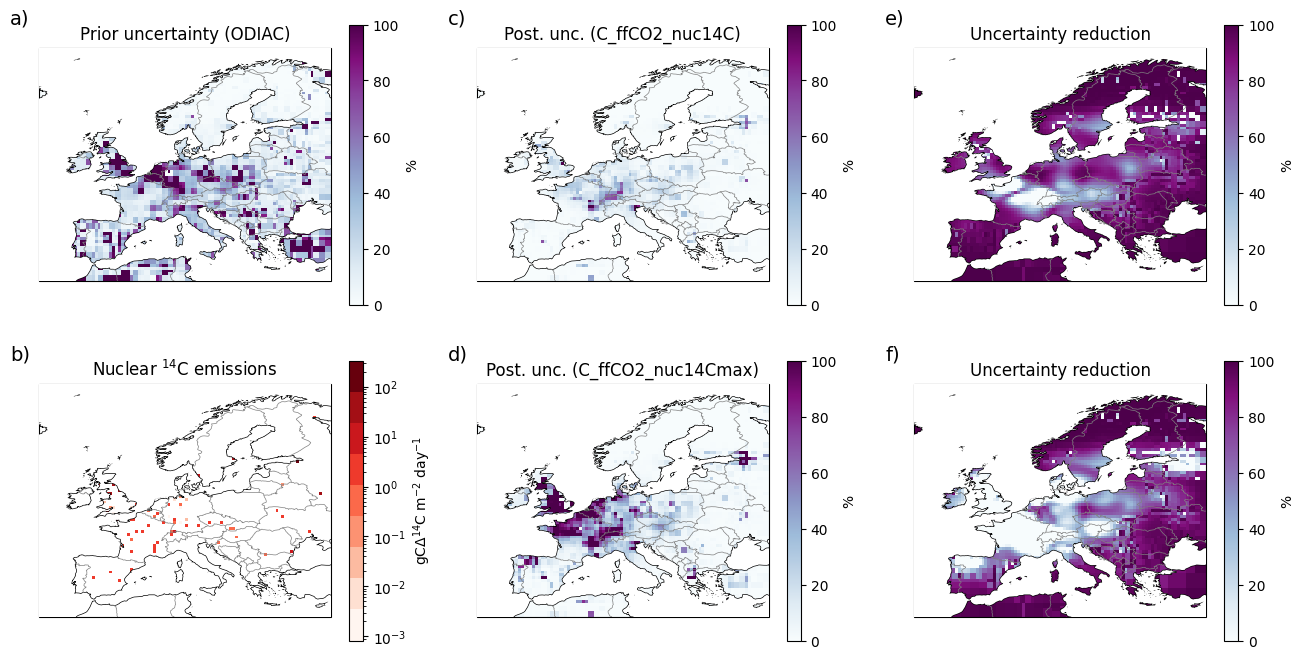

In [38]:
f, ax = subplots(2, 3, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ds_apri = open_dataset('data/fig7/fig7_prior.nc')
ds_apri_unc = open_dataset('data/fig7/fig7_prior_unc.nc')

# Calculate relative uncertainty
ds_apri_unc_rel = ds_apri_unc / ds_apri * 100

p = ds_apri_unc_rel.emis.plot(ax=ax[0, 0], transform=ccrs.PlateCarree(), cmap='BuPu', extend='neither', vmin=0, vmax=100)
ax[0, 0].coastlines()
ax[0, 0].set_title('Prior uncertainty (ODIAC)')
ax[0, 0].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
ax[0, 0].add_feature(cfeature.OCEAN, facecolor='white', zorder=10)
colorbar = p.colorbar
colorbar.set_label('%')

ds_nuclear = open_dataset('data/fig7/fig7_nuclear.nc')

emis = ds_nuclear.isel(time=1).emis

log_levels = logspace(log10(emis.values[emis>0].min()), log10(emis.max()), num=10)

# Plot the data with a logarithmic color scale
p = emis.plot.pcolormesh(ax=ax[1,0], x='lon', y='lat', norm=LogNorm(), levels=log_levels, cmap='Reds', vmin = log_levels.min(), vmax = log_levels.max(), extend='neither')
ax[1, 0].coastlines()
ax[1, 0].set_title('Nuclear $^{14}$C emissions')
ax[1, 0].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
ax[1, 0].add_feature(cfeature.OCEAN, facecolor='white', zorder=10)
# Change the colorbar label
colorbar = p.colorbar
colorbar.set_label('gC$\Delta^{14}$C m$^{-2}$ day$^{-1}$')

ds_apos1 = open_dataset('data/fig7/fig7_post_nuc14Cmin.nc')
ds_apos1_unc = open_dataset('data/fig7/fig7_post_unc_nuc14Cmin.nc')

# Calculate relative uncertainty
ds_apos1_unc_rel = ds_apos1_unc / ds_apos1 * 100

p = ds_apos1_unc_rel.emis.plot(ax=ax[0, 1], transform=ccrs.PlateCarree(), cmap='BuPu', extend='neither', vmin=0, vmax=100)
ax[0, 1].coastlines()
ax[0, 1].set_title('Post. unc. (C_ffCO2_nuc14C)')
ax[0, 1].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
ax[0, 1].add_feature(cfeature.OCEAN, facecolor='white', zorder=10)
colorbar = p.colorbar
colorbar.set_label('%')

ds_apos2 = open_dataset('data/fig7/fig7_post_nuc14Cmax.nc')
ds_apos2_unc = open_dataset('data/fig7/fig7_post_unc_nuc14Cmax.nc')

# Calculate relative uncertainty
ds_apos2_unc_rel = ds_apos2_unc / ds_apos2 * 100

p = ds_apos2_unc_rel.emis.plot(ax=ax[1, 1], transform=ccrs.PlateCarree(), cmap='BuPu', extend='neither', vmin=0, vmax=100)
ax[1, 1].coastlines()
ax[1, 1].set_title('Post. unc. (C_ffCO2_nuc14Cmax)')
ax[1, 1].add_feature(cfeature.OCEAN, facecolor='white', zorder=10)
ax[1, 1].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
colorbar = p.colorbar
colorbar.set_label('%')

# Calculate the difference between the posterior and the prior in percentage
diff1 = (1 - ds_apos1_unc/ds_apri_unc) * 100
diff2 = (1 - ds_apos2_unc/ds_apri_unc) * 100

p = diff1.emis.plot(ax=ax[0, 2], transform=ccrs.PlateCarree(), cmap='BuPu', extend='neither', vmin=0, vmax=100)
ax[0, 2].coastlines()
ax[0, 2].set_title('Uncertainty reduction')
ax[0, 2].add_feature(cfeature.OCEAN, facecolor='white', zorder=10)
ax[0, 2].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
colorbar = p.colorbar
colorbar.set_label('%')

p = diff2.emis.plot(ax=ax[1, 2], transform=ccrs.PlateCarree(), cmap='BuPu', extend='neither', vmin=0, vmax=100)
ax[1, 2].coastlines()
ax[1, 2].set_title('Uncertainty reduction')
ax[1, 2].add_feature(cfeature.OCEAN, facecolor='white', zorder=10)
ax[1, 2].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
colorbar = p.colorbar
colorbar.set_label('%')

# Add letters to the subplots
lbl = ['a)', 'c)', 'e)', 'b)', 'd)', 'f)']
for i in range(6):
    ax[int(i/3), i%3].text(-0.1, 1.1, lbl[i], transform=ax [int(i/3), i%3].transAxes, fontsize=14)

f.savefig('figures/fig7.png', dpi=300, bbox_inches='tight')

In [24]:
# TODO: Preprocessing, you can remove this cell

path = '/home/carlosg/lu2023-12-19/carlos/data/output'

osses = [
'ensemble_CORSO_ffCO2_nuc14Cmin_nuclear/CORSO_ffCO2_nuc14Cmin_nuclear_',
'ensemble_CORSO_ffCO2_nuc14Cmax_nuclear/CORSO_ffCO2_nuc14Cmax_nuclear_',
 ]

alias = [
    'C_ff_nuc14C',
    'C_ff_nuc14Cmax',
]

cat = 'co2/fossil'
time_span = 'Annual'

Regions = ['Western Europe', 'DE', 'FR', 'Benelux', 'CH', 'DK', 'CZ', 'British Isles', '']
Reg = ['Western/Central Europe', 'Germany', 'France', 'Benelux', 'Switzerland', 'Denmark', 'Czech Republic', 'British Isles']

df_all = DataFrame()

for i, reg in enumerate(Regions):

    ds_apri, unit = toTimeUnits(os.path.join(path, 'Paper2/Experiments1/CORSO_ffCO2_ffCO', 'modelData.apri.nc'), cat, time_span, reg)

    df_all.loc[:, 'time'] = ds_apri.time.values
    df_all.loc[:, f'prior {reg}'] = ds_apri.emis.values

    ds_apri_unc = []
    for k in range(100):
        try:
            d, u = toTimeUnits(os.path.join(path, f'ensemble_CORSO_BAU/CORSO_BAU_{k}', f'modelData.apri.nc'), cat, time_span, reg)
            ds_apri_unc.append(d.emis.values)
        except:
            pass
    
    ds_apri_unc = array(ds_apri_unc)
    ds_apri_unc = ds_apri_unc.std(axis=0)

    df_all.loc[:, f'prior unc {reg}'] = ds_apri_unc
    df_all.loc[:, f'prior unc rel {reg}'] = ds_apri_unc / ds_apri.emis.values

    for j, osse in enumerate(osses):

        # Plot the mean
        if 'min' in osse:
            osse1 = 'Paper2/Experiments1/CORSO_ffCO2_nuc14Cmin'
        elif 'max' in osse:
            osse1 = 'Paper2/Experiments1/CORSO_ffCO2_nuc14Cmax'
        ds_apos, unit = toTimeUnits(os.path.join(path, osse1, 'modelData.apos.nc'), cat, time_span, reg)

        df_all.loc[:, f'post {alias[j]} {reg}'] = ds_apos.emis.values

        ds_apos_unc = []
        for k in range(100):
            try:
                d, u = toTimeUnits(os.path.join(path, osse+f'{k}', 'modelData.apos.nc'), cat, time_span, reg)
                ds_apos_unc.append(d.emis.values)
            except:
                pass
        
        # Plot the std
        ds_apos_unc = array(ds_apos_unc)
        ds_apos_unc = ds_apos_unc.std(axis=0)

        df_all.loc[:, f'post unc {alias[j]} {reg}'] = ds_apos_unc
        df_all.loc[:, f'post unc rel {alias[j]} {reg}'] = ds_apos_unc / ds_apri_unc
        df_all.loc[:, f'post unc red {alias[j]} {reg}'] = 1 - ds_apos_unc / ds_apri_unc

df_all.to_csv('data/fig7/fig7.csv')

In [43]:
consult = [col for col in df_all.columns if 'British Isles' in col]

(df_all[consult] * 100).round(0)

,prior British Isles,prior unc British Isles,prior unc rel British Isles,post C_ff_nuc14C British Isles,post unc C_ff_nuc14C British Isles,post unc rel C_ff_nuc14C British Isles,post unc red C_ff_nuc14C British Isles,post C_ff_nuc14Cmax British Isles,post unc C_ff_nuc14Cmax British Isles,post unc rel C_ff_nuc14Cmax British Isles,post unc red C_ff_nuc14Cmax British Isles
0,3.0,3.0,122.0,3.0,1.0,18.0,82.0,3.0,5.0,162.0,-62.0
1,10.0,9.0,93.0,12.0,2.0,17.0,83.0,12.0,16.0,178.0,-78.0
2,2.0,3.0,159.0,2.0,1.0,25.0,75.0,2.0,5.0,157.0,-57.0


[Back to Top](#top)

### Appendix A1.

In [11]:
# Run this cell to load the synthetic data into a DataFrame

Forward_CORSO_HRLY_13LT = read_csv('data/fig2/fig2.csv', parse_dates=['time', 'time_LT'])

Forward_CORSO_HRLY_13LT = Forward_CORSO_HRLY_13LT.set_index('time', drop=False)

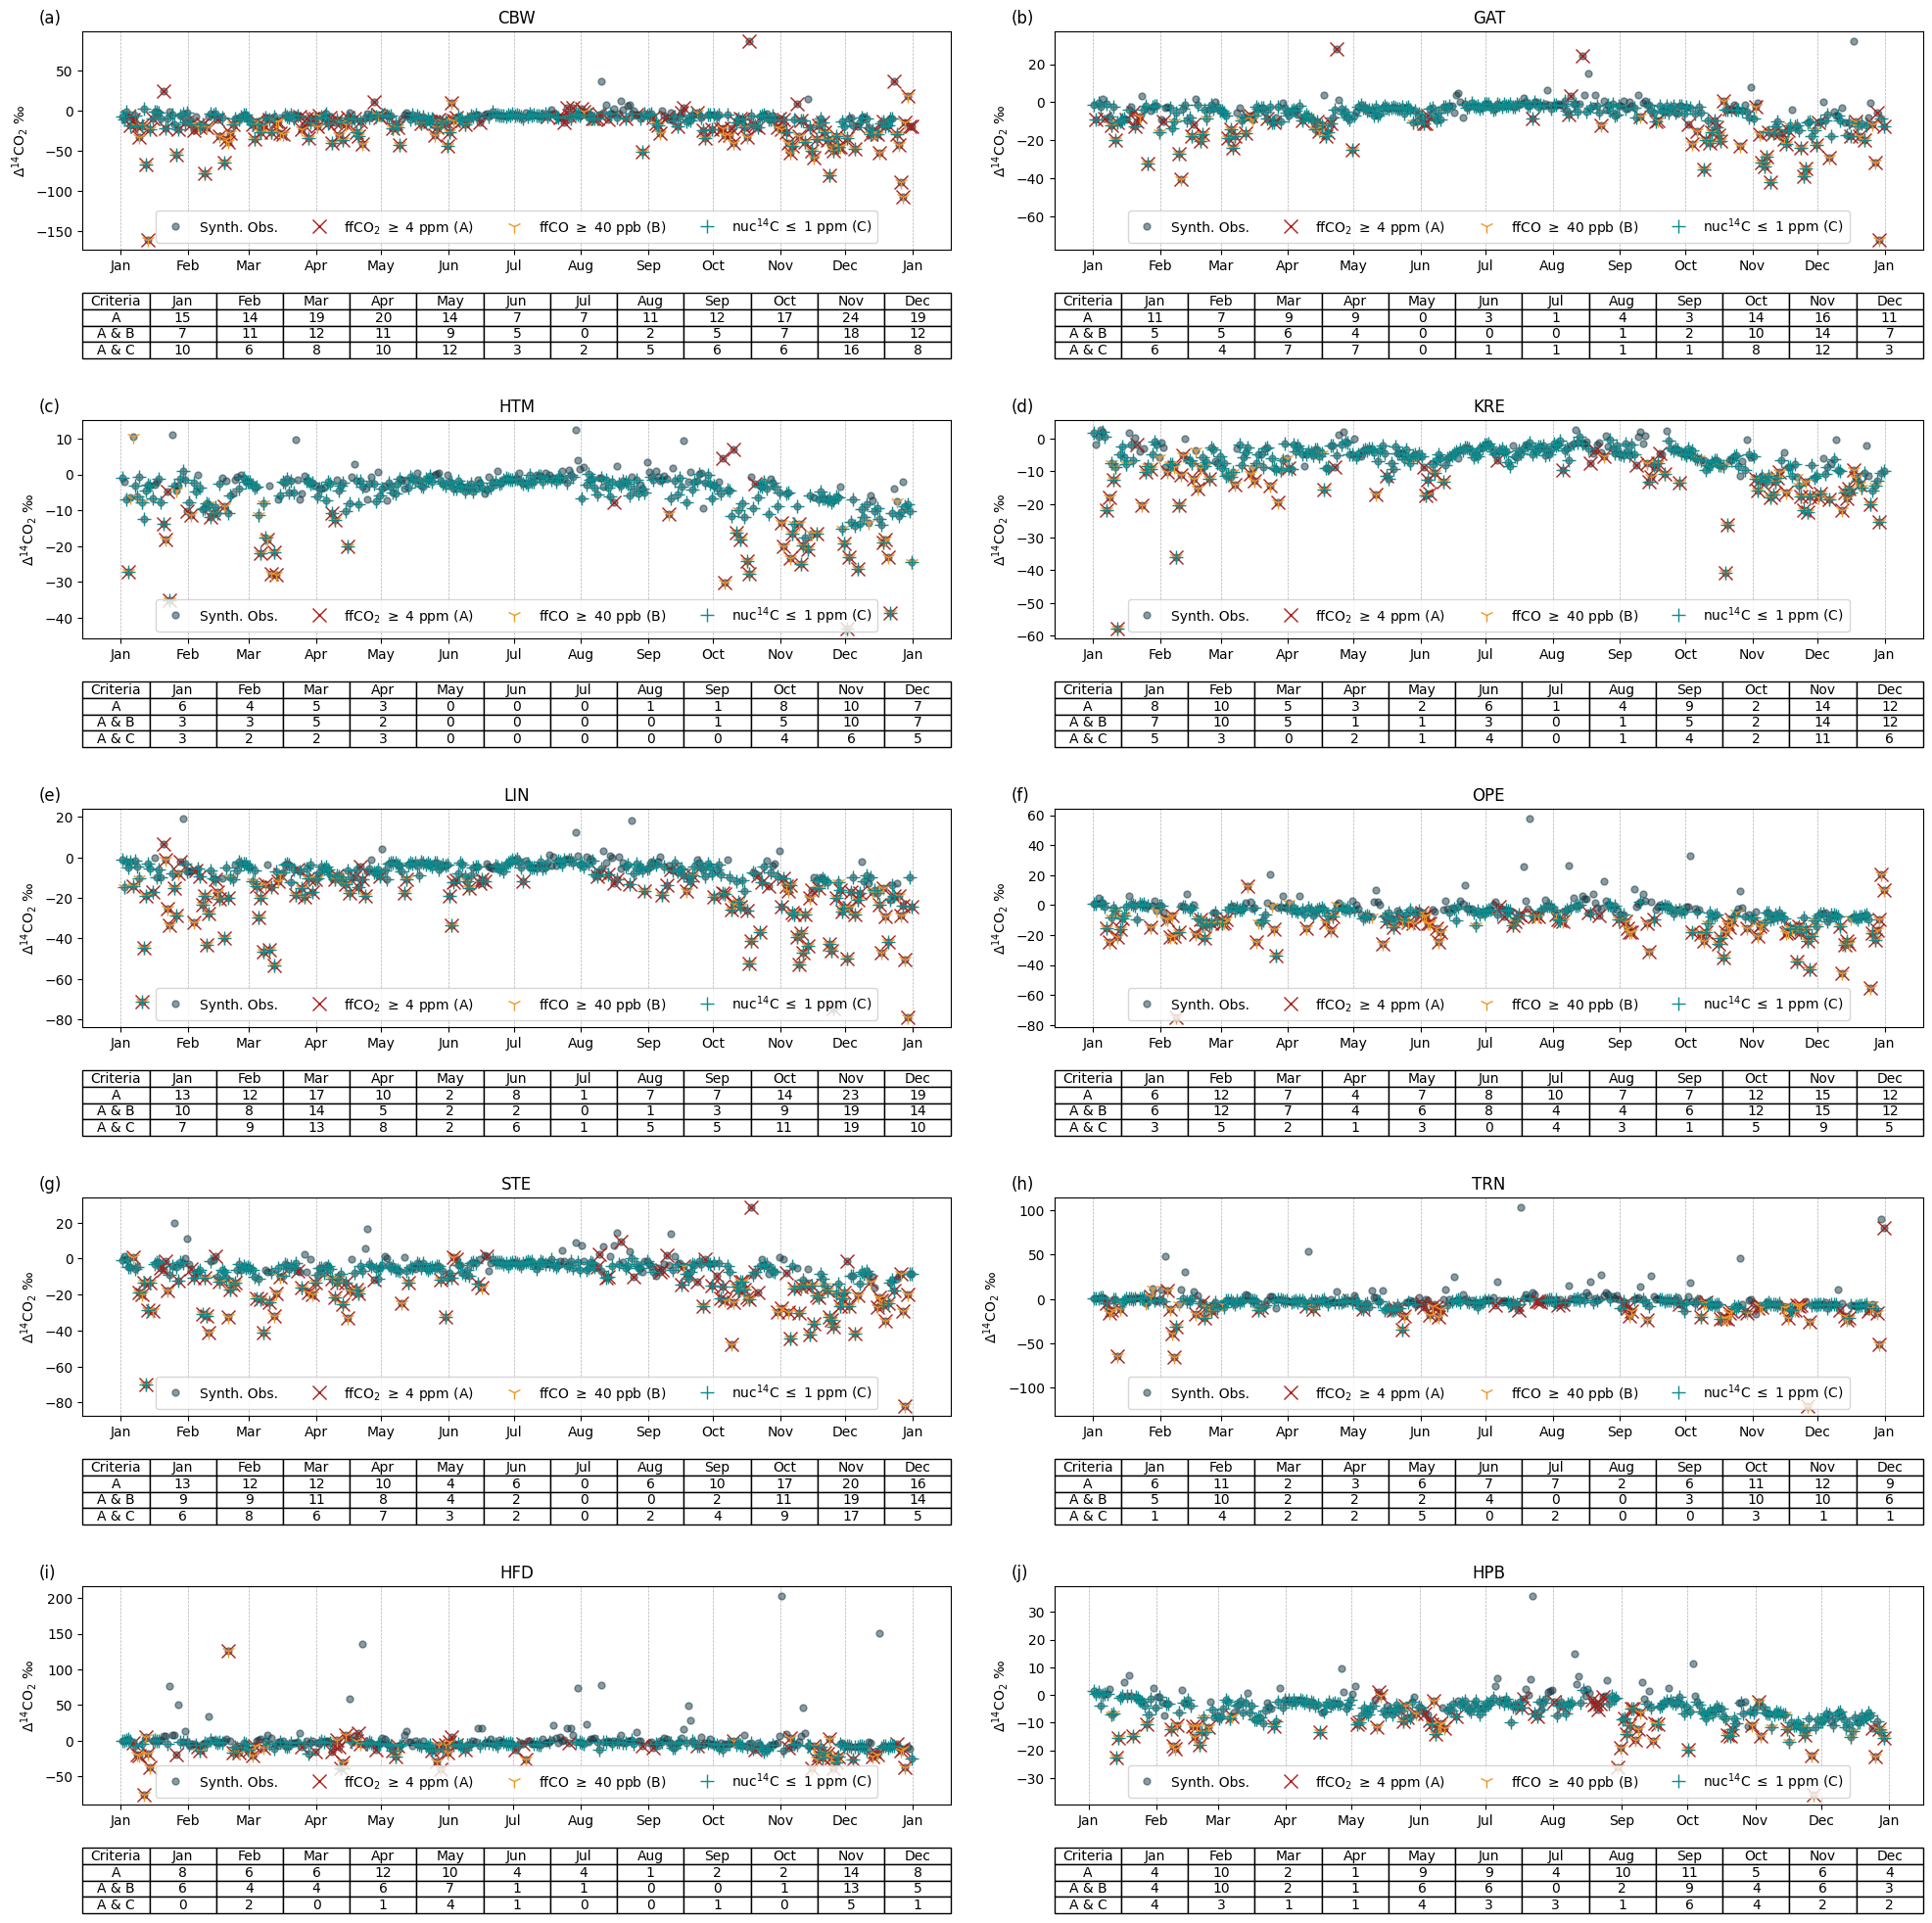

In [13]:
f, ax = subplots(5, 2, figsize=(20, 20))

ax = ax.flatten()

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#A8201A', '#143642']

for i, site in enumerate(Forward_CORSO_HRLY_13LT.loc[~Forward_CORSO_HRLY_13LT.site.isin(['KIT', 'BIK'])].site.unique()):

    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site)].obs_permil, label='Synth. Obs.', lw=0, marker='o', markersize=5, color=clr[-1], alpha=0.5) 
    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO2 == 1)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO2 == 1)].obs_permil, label=r'ffCO$_2$ $\geq$ 4 ppm (A)', lw=0, marker='x', markersize=10, color=clr[3]) 
    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO == 1)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.ffCO == 1)].obs_permil, label=r'ffCO $\geq$ 40 ppb (B)', lw=0, marker='1', markersize=10, color=clr[1]) 
    ax[i].plot(Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.nuc14C == 1)].time, Forward_CORSO_HRLY_13LT.loc[(Forward_CORSO_HRLY_13LT.site == site) & (Forward_CORSO_HRLY_13LT.nuc14C == 1)].obs_permil, label=r'nuc$^{14}$C $\leq$ 1 ppm (C)', lw=0, marker='+', markersize=10, color=clr[0]) 

    ax[i].grid(which='major', axis='x', linestyle='--', linewidth=0.5)

    # Select only numeric columns for resampling
    numeric_columns = Forward_CORSO_HRLY_13LT.loc[Forward_CORSO_HRLY_13LT.site == site].select_dtypes(include=['number'])

    # Set the index and resample
    monthly_counts = numeric_columns.resample('M').sum()

    table_data = [
        ['A'] + list(monthly_counts['ffCO2']),
        ['A & B'] + list((monthly_counts['ffCO2_ffCO'])),
        ['A & C'] + list((monthly_counts['ffCO2_nuc14C']))
    ]

    months = mdates.MonthLocator()  # set the locator to months
    date_fmt = mdates.DateFormatter('%b')  # set the formatter to month abbreviations
    ax[i].xaxis.set_major_locator(months)
    ax[i].xaxis.set_major_formatter(date_fmt)
    # Make the x-axis label horizontal 
    for tick in ax[i].get_xticklabels():
       tick.set_rotation(0)
       tick.set_horizontalalignment("center")
    
    months_labels = [datetime(2018, m, 1).strftime('%b') for m in range(1, 13)]
    table = ax[i].table(cellText=table_data, colLabels=['Criteria'] + months_labels, cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)
    
    ax[i].set_ylabel(r'$\Delta^{14}$CO$_2$ ‰')

    ax[i].legend(ncols=4, loc='lower center')
    ax[i].set_title(site)

    # Add letter labels
    ax[i].text(-0.05, 1.1, f'({chr(97 + i)})', transform=ax[i].transAxes, fontsize=12, va='top')

f.tight_layout()

f.savefig('figures/A1.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)

### Appendix A2.

In [21]:
db_3t_real_wk = read_csv('data/fig3/fig3_real.csv', parse_dates=['time'])
db_flex = read_csv('data/fig3/fig3_synth.csv', parse_dates=['time'])

/tmp/ipykernel_684554/2186344334.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_flex_site['time'] = db_flex_site.time.dt.date
/tmp/ipykernel_684554/2186344334.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_3t_real_wk_site['time'] = db_3t_real_wk_site.time.dt.date
/tmp/ipykernel_684554/2186344334.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

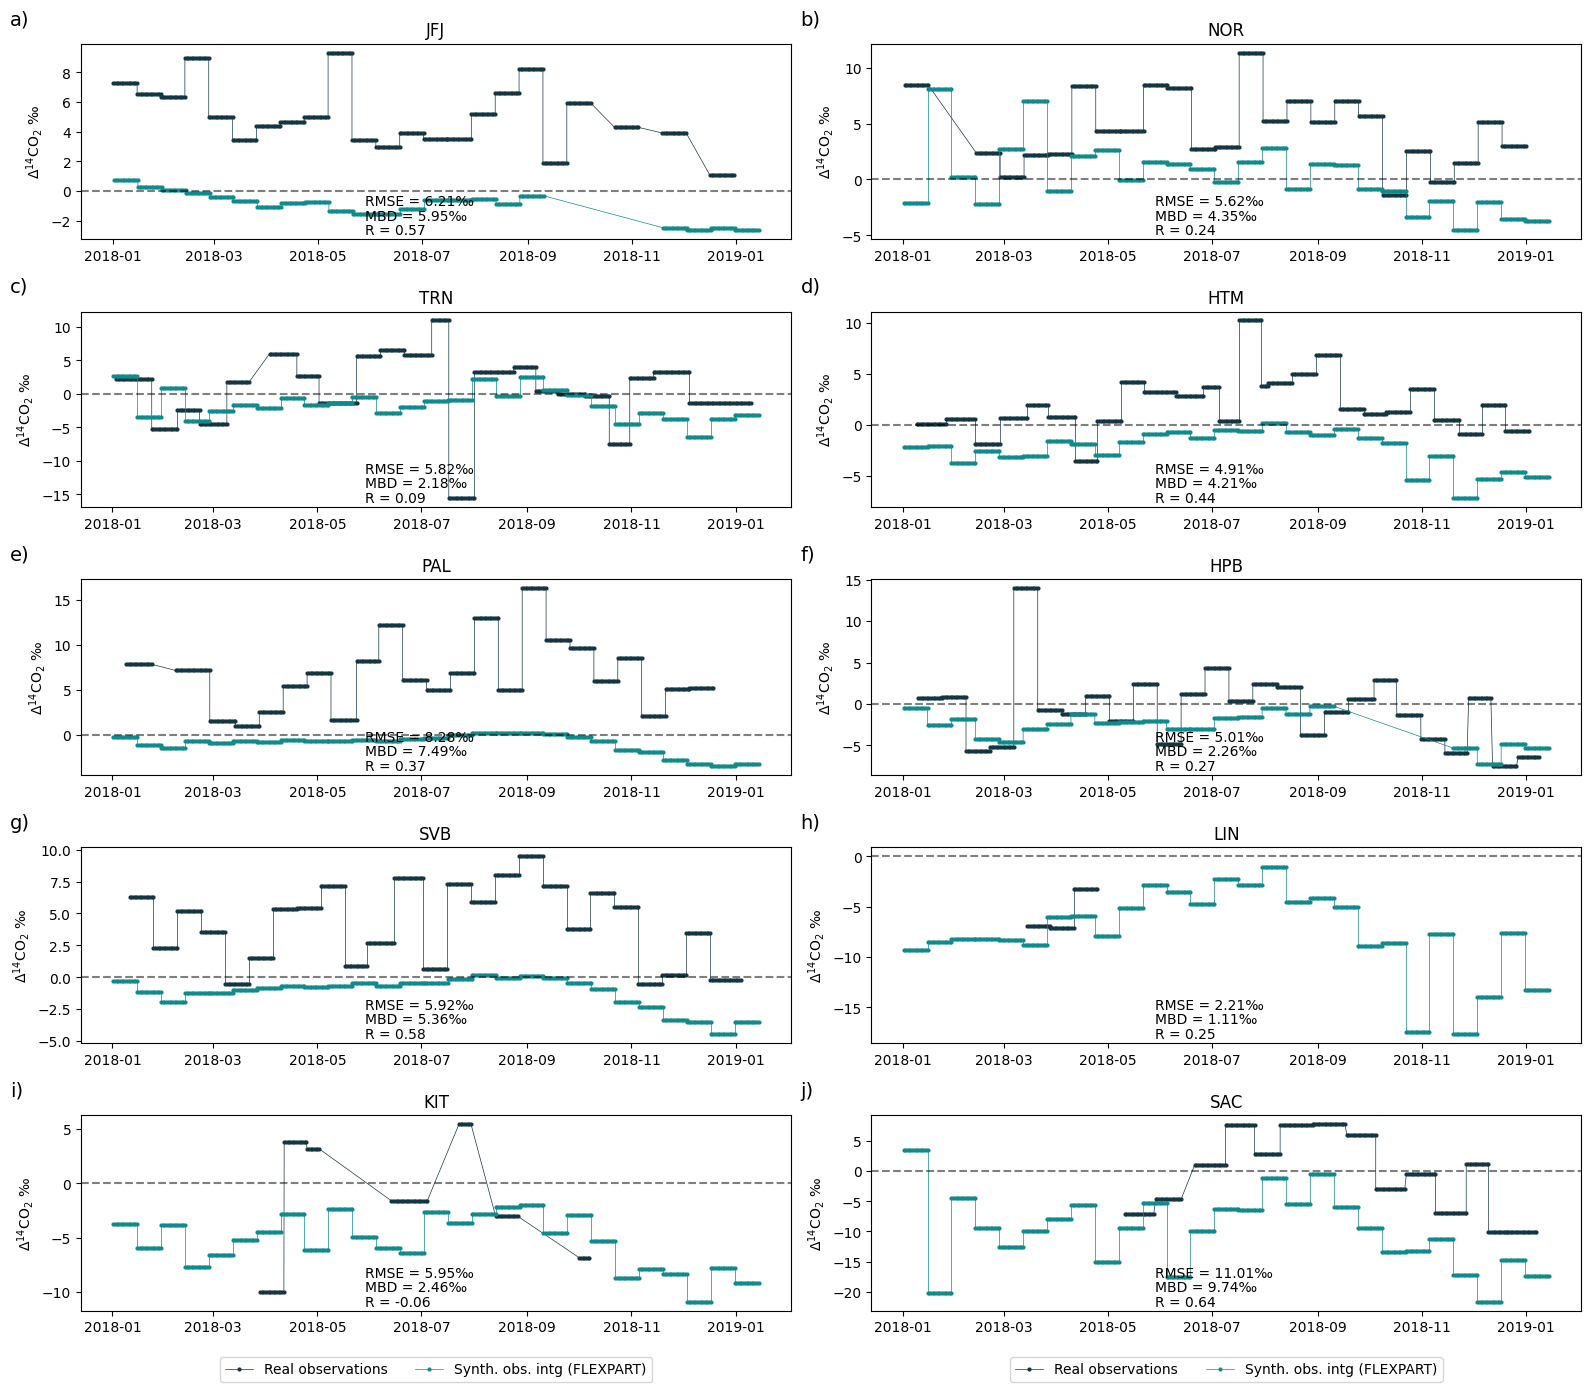

In [22]:
f, ax = subplots(5, 2, figsize=(16,14))#, sharex=True)

ax = ax.flatten()

tr = ['CO2', 'D14C']
lbl = ['ppm', 'permil']

tracer = 'c14'

clr = ['#0F8B8D', '#EC9A29', '#7D6F86', '#A8201A', '#143642']

for i, site in enumerate(db_3t_real.loc[~db_3t_real.site.isin(['CBW', 'KRE', 'OPE'])].site.unique()):

    ax[i].plot(db_3t_real_wk.loc[(db_3t_real_wk.site == site), 'time'], db_3t_real_wk.loc[(db_3t_real_wk.site == site), 'obs_permil'], color=clr[-1], label='Real observations', lw=0.5, marker='o', markersize=2)

    ax[i].plot(db_flex.loc[(db_flex.site == site), 'time'], db_flex.loc[(db_flex.site == site), 'obs_permil'], color=clr[0], label='Synth. obs. intg (FLEXPART)', lw=0.5, marker='o', markersize=2)

    # Calculate R^2
    db_flex_site = db_flex.loc[(db_flex.site == site)]
    db_flex_site['time'] = db_flex_site.time.dt.date

    db_3t_real_wk_site = db_3t_real_wk.loc[(db_3t_real_wk.site == site)]
    db_3t_real_wk_site['time'] = db_3t_real_wk_site.time.dt.date

    db_con = merge(db_3t_real_wk_site, db_flex_site, on='time', how='outer')

    db_con = db_con.loc[~db_con.obs_permil_x.isna()]
    db_con = db_con.loc[~db_con.obs_permil_y.isna()]

    R = db_con.obs_permil_x.corr(db_con.obs_permil_y)
    MBD = db_con.obs_permil_x.subtract(db_con.obs_permil_y).mean()
    # Calculate RMSE
    RMSE = sqrt(mean((db_con.obs_permil_x - db_con.obs_permil_y)**2))

    ax[i].text(0.4, 0.025, f'R = {R:.2f}', transform=ax[i].transAxes)
    ax[i].text(0.4, 0.1, f'MBD = {MBD:.2f}‰', transform=ax[i].transAxes)
    ax[i].text(0.4, 0.175, f'RMSE = {RMSE:.2f}‰', transform=ax[i].transAxes)

    ax[i].set_title(f'{site}')
    ax[i].set_ylabel('$\Delta^{14}$CO$_2$ ‰') 

    lbl = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)', 't)', 'u)', 'v)', 'w)', 'x)', 'y)', 'z)']

    ax[i].text(-0.1, 1.1, lbl[i], transform=ax[i].transAxes, fontsize=14)
    # Put a legend below current axis
    if (i == 9) or (i == 8):
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

    # Add a dashed line at 0
    ax[i].axhline(0, color='k', linestyle='--', alpha=0.5)

f.tight_layout()

f.savefig('figures/A2.png', dpi=300, bbox_inches='tight')

[Back to Top](#top)